# Exploratory Data Analysis
What the fuck we got goin' on here

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

from zenodo:
Filename identifiers 

- 01 -> Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- 02 -> Vocal channel (01 = speech, 02 = song).
- 03 -> Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- 04 -> Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- 05 -> Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- 06 -> Repetition (01 = 1st repetition, 02 = 2nd repetition).
- 07 -> Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


In [2]:
modality = ['full-av', 'video-only', 'audio-only']
vocal_channel = ['speech', 'song']
emotion = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
intensity = ['normal', 'strong']

In [7]:
data_dir = '../data'
wav_paths = glob.glob(os.path.join(data_dir, 'Actor_*', '*.wav'))

rows = []
for p in wav_paths:
    fname = os.path.basename(p)
    # ravdess goes
    # modality - channel - emotion - intensity - statement - repetition - actor
    parts = fname.replace('.wav', '').split('-')
    rows.append({
        'path': p,
        'modality': parts[0],
        'vocal_channel': parts[1],
        'emotion': emotion[int(parts[2])-1],
        'intensity': parts[3],
        'statement': parts[4],
        'repetition': parts[5],
        'actor': parts[6]
    })

meta = pd.DataFrame(rows)
print(f"Total samples: {len(meta)}")
print("Emotions present:", sorted(meta['emotion'].unique()))
print("Counts by emotion:")
print(meta['emotion'].value_counts())

Total samples: 1440
Emotions present: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Counts by emotion:
emotion
happy        192
surprised    192
disgust      192
calm         192
fearful      192
sad          192
angry        192
neutral       96
Name: count, dtype: int64


In [35]:
meta.head()

,path,modality,vocal_channel,emotion,intensity,statement,repetition,actor,duration
0,../data/Actor_07/03-01-03-01-02-01-07.wav,03,01,happy,01,02,01,07,3.403396
1,../data/Actor_07/03-01-08-02-02-02-07.wav,03,01,surprised,02,02,02,07,3.470125
2,../data/Actor_07/03-01-08-01-01-02-07.wav,03,01,surprised,01,01,02,07,3.536875
3,../data/Actor_07/03-01-07-02-01-01-07.wav,03,01,disgust,02,01,01,07,4.137479
4,../data/Actor_07/03-01-03-01-01-02-07.wav,03,01,happy,01,01,02,07,3.470125


In [37]:
def get_duration(path):
    return librosa.get_duration(path=path)

meta['duration'] = meta['path'].map(get_duration)

meta.describe()


,duration
count,1440.000000
mean,3.700665
std,0.336676
min,2.936271
25%,3.470146
50%,3.670333
75%,3.870542
max,5.271937


In [38]:
# get path with smallest duration
print(meta.loc[meta['duration'].idxmin()])

path             ../data/Actor_13/03-01-02-01-02-02-13.wav
modality                                                03
vocal_channel                                           01
emotion                                               calm
intensity                                               01
statement                                               02
repetition                                              02
actor                                                   13
duration                                          2.936271
Name: 1435, dtype: object


In [10]:
def get_mfcc(path):
    n_mfcc = 13
    y, sr = librosa.load(path, sr=16000)
    return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

mfcc_shapes = []

for path in meta['path']:
    mfcc = get_mfcc(path)
    mfcc_shapes.append(mfcc.shape)

mfcc_shapes = pd.DataFrame(mfcc_shapes)
mfcc_shapes.describe()

,0,1
count,1440.0,1440.000000
mean,13.0,116.124306
std,0.0,10.480955
min,13.0,92.000000
25%,13.0,109.000000
50%,13.0,115.000000
75%,13.0,121.000000
max,13.0,165.000000


In [11]:
def get_chroma(path):
    n_mfcc = 13
    y, sr = librosa.load(path, sr=16000)
    return librosa.feature.chroma_stft(y=y, sr=sr)

chroma_shapes = []

for path in meta['path']:
    chroma = get_chroma(path)
    chroma_shapes.append(chroma.shape)

chroma_shapes = pd.DataFrame(chroma_shapes)
chroma_shapes.describe()

,0,1
count,1440.0,1440.000000
mean,12.0,116.124306
std,0.0,10.480955
min,12.0,92.000000
25%,12.0,109.000000
50%,12.0,115.000000
75%,12.0,121.000000
max,12.0,165.000000


MFCC shape: (13, 295)


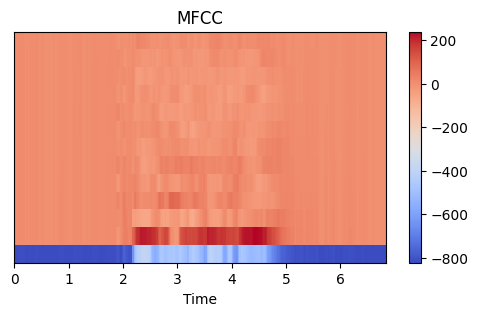

Chroma shape: (12, 295)


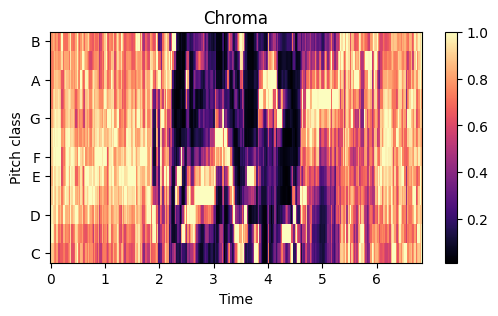

In [40]:
# pick one sample
path = meta['path'].iloc[-1]
y, sr = librosa.load(path, sr=None)

# MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
print("MFCC shape:", mfcc.shape)  # (n_mfcc, frames)

plt.figure(figsize=(6,3))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

# Chroma
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
print("Chroma shape:", chroma.shape)  # (12, frames)

plt.figure(figsize=(6,3))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma')
plt.show()

<Figure size 800x400 with 0 Axes>

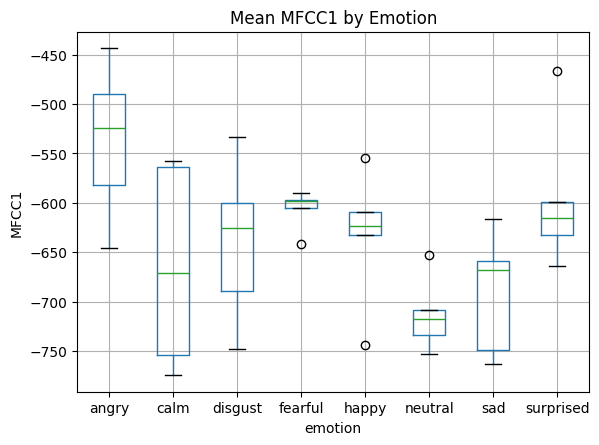

In [14]:
# for speed: sample a few files per emotion
grouped = meta.groupby('emotion').sample(5, random_state=0)

mfcc_stats = []
for _, row in grouped.iterrows():
    y, sr = librosa.load(row['path'], sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_stats.append({
        'emotion': row['emotion'],
        **{f'mfcc{i+1}_mean': mfcc[i].mean() for i in range(13)}
    })
mfcc_stats_df = pd.DataFrame(mfcc_stats)

# boxplot of, say, mfcc1_mean by emotion
plt.figure(figsize=(8,4))
mfcc_stats_df.boxplot(column='mfcc1_mean', by='emotion')
plt.title('Mean MFCC1 by Emotion')
plt.suptitle('')
plt.ylabel('MFCC1')
plt.show()

<Figure size 800x400 with 0 Axes>

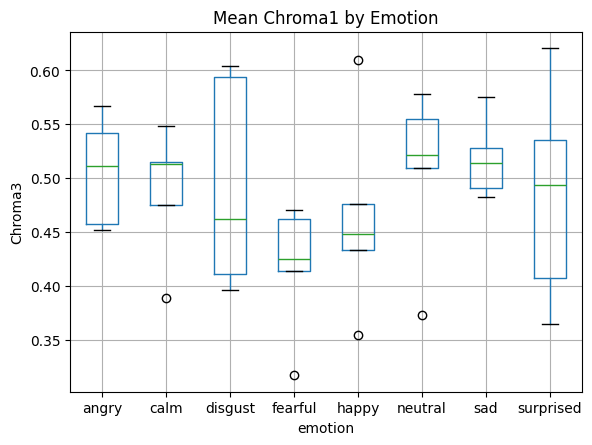

In [21]:
# for speed: sample a few files per emotion
grouped = meta.groupby('emotion').sample(5, random_state=0)

chroma_stats = []
for _, row in grouped.iterrows():
    y, sr = librosa.load(row['path'], sr=None)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12)
    chroma_stats.append({
        'emotion': row['emotion'],
        **{f'chroma{i+1}_mean': chroma[i].mean() for i in range(12)}
    })
chroma_stats_df = pd.DataFrame(chroma_stats)

# boxplot of, say, mfcc1_mean by emotion
plt.figure(figsize=(8,4))
chroma_stats_df.boxplot(column='chroma3_mean', by='emotion')
plt.title('Mean Chroma1 by Emotion')
plt.suptitle('')
plt.ylabel('Chroma3')
plt.show()

# DataLoader
I'm gonna make a feature vector with chroma and MFCC data, God willing.

In [22]:
emotions = sorted(meta['emotion'].unique())
emotion2idx = {emo: i for i, emo in enumerate(emotions)}

In [42]:
from tqdm import tqdm  # for progress bar
import torch

# Hyper-params (must match what you use later)
SR = None
N_MFCC = 13
N_CHROMA = 12

# Lists to hold your tensors and labels
feats_cache = []
labels_cache = []

print("Pre-computing features…")
for _, row in tqdm(meta.iterrows(), total=len(meta)):
    y, sr = librosa.load(row['path'], sr=SR)
    mfcc   = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=N_CHROMA)
    feats  = np.vstack([mfcc, chroma]).T            # (frames, feat_dim)
    tensor = torch.from_numpy(feats).float()
    label  = torch.tensor(emotion2idx[row['emotion']], dtype=torch.long)
    feats_cache.append(tensor)
    labels_cache.append(label)
    # print(f"mfcc: {mfcc.shape}, chroma: {chroma.shape}, label: {row['emotion']}")

# Optionally save to disk for later sessions:
torch.save((feats_cache, labels_cache), "ravdess_feats.pt")
print("Done! Cached", len(feats_cache), "samples.")

Pre-computing features…


100%|██████████| 1440/1440 [01:00<00:00, 23.84it/s]


Done! Cached 1440 samples.


# Cached DataLoader

Since I'm baller as fuck I precalculated all the chromosomes and mfcc's and saved it in a file to load later so I don't bog down my poor PC with doing a lot of math all the time

In [50]:
import torch
from torch.utils.data import Dataset
import librosa
import numpy as np

class CachedRAVDESSDataset(Dataset):
    def __init__(self, feats, labels):
        self.feats  = feats
        self.labels = labels

    def __len__(self):
        return len(self.feats)

    def __getitem__(self, idx):
        return self.feats[idx], self.labels[idx]

In [51]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
    """
    batch: list of (feat_tensor [T_i×D], label)
    returns:
      - feats: (B, T_max, D) padded with zeros
      - lengths: (B,) original T_i
      - labels: (B,)
    """
    feats, labels = zip(*batch)
    lengths = torch.tensor([f.shape[0] for f in feats], dtype=torch.long)
    # pad to the max T in this batch
    feats_padded = pad_sequence(feats, batch_first=True)  # zeros out the shorter ones
    labels = torch.stack(labels)
    return feats_padded, lengths, labels

In [52]:
from torch.utils.data import DataLoader

feats_cache, labels_cache = torch.load("ravdess_feats.pt")

# Instantiate dataset & DataLoader
dataset = CachedRAVDESSDataset(feats_cache, labels_cache)
loader  = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=pad_collate,
    num_workers=2,
    pin_memory=False
)

In [53]:
for feats, lengths, labels in loader:
    print("feats:", feats.shape)    # e.g. (32, T_max, 25)
    print("lengths:", lengths)      # e.g. tensor([200, 180, 240, …])
    print("labels:", labels.shape)  # (32,)
    break

feats: torch.Size([32, 460, 25])
lengths: tensor([291, 329, 460, 363, 316, 360, 329, 313, 351, 345, 279, 341, 298, 329,
        410, 370, 326, 385, 410, 398, 348, 291, 335, 313, 385, 326, 420, 338,
        348, 366, 351, 376])
labels: torch.Size([32])


In [ ]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class LSTMClassifier(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 num_layers: int,
                 num_classes: int,
                 bidirectional: bool = True,
                 dropout: float = 0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      bidirectional=bidirectional,
                      batch_first=True,
                      dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), num_classes)

    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, (h_n, c_n) = self.lstm(packed)

        if self.lstm.bidirectional:
            n_layers = self.lstm.num_layers
            H = self.lstm.hidden_size
            h_n = h_n.view(n_layers, 2, -1, H)
            h_fwd = h_n[-1, 0]
            h_bwd = h_n[-1, 1]
            h = torch.cat([h_fwd, h_bwd], dim=-1)
        else:
            h = h_n[-1]

        out = self.dropout(h)
        logits = self.fc(out)
        return logits

In [ ]:
import torch.optim as optim

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct = 0.0, 0
    for feats, lengths, labels in loader:
        feats, lengths, labels = feats.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(feats, lengths)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / len(loader.dataset)
    return avg_loss, accuracy

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0.0, 0
    with torch.no_grad():
        for feats, lengths, labels in loader:
            feats, lengths, labels = feats.to(device), lengths.to(device), labels.to(device)
            logits = model(feats, lengths)
            loss = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / len(loader.dataset)
    return avg_loss, accuracy


In [ ]:
# 3.1 Hyper-parameters & setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size   = 13 + 12             # MFCCs + Chroma
hidden_size  = 128
num_layers   = 2
num_classes  = len(emotion2idx)
lr           = 1e-3
batch_size   = 32
num_epochs   = 30

# 3.2 Instantiate
model     = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optional scheduler:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='max',
                                                 patience=3,
                                                 factor=0.5)

# 3.3 Training loop
best_val_acc = 0.0
for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, loader, criterion, optimizer, device)
    val_loss,   val_acc   = eval_epoch(model, loader, criterion, device)  # or a separate val_loader

    print(f"Epoch {epoch:02d}  "
          f"Train: loss={train_loss:.3f}, acc={train_acc:.3f}  "
          f"Val:   loss={val_loss:.3f}, acc={val_acc:.3f}")

    # step scheduler on val_acc
    scheduler.step(val_acc)

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_lstm_emotion.pth")

print(f"Best val acc: {best_val_acc:.3f}")

Epoch 01  Train: loss=2.051, acc=0.144  Val:   loss=1.925, acc=0.221
Epoch 02  Train: loss=1.859, acc=0.258  Val:   loss=1.741, acc=0.301
Epoch 03  Train: loss=1.804, acc=0.276  Val:   loss=1.704, acc=0.323
Epoch 04  Train: loss=1.715, acc=0.301  Val:   loss=1.647, acc=0.330
Epoch 05  Train: loss=1.666, acc=0.352  Val:   loss=1.568, acc=0.383
Epoch 06  Train: loss=1.623, acc=0.348  Val:   loss=1.520, acc=0.380
Epoch 07  Train: loss=1.594, acc=0.360  Val:   loss=1.566, acc=0.378
Epoch 08  Train: loss=1.574, acc=0.374  Val:   loss=1.461, acc=0.421
Epoch 09  Train: loss=1.577, acc=0.394  Val:   loss=1.555, acc=0.390
Epoch 10  Train: loss=1.534, acc=0.398  Val:   loss=1.399, acc=0.433
Epoch 11  Train: loss=1.462, acc=0.421  Val:   loss=1.379, acc=0.460
Epoch 12  Train: loss=1.447, acc=0.436  Val:   loss=1.349, acc=0.480
Epoch 13  Train: loss=1.418, acc=0.455  Val:   loss=1.337, acc=0.501
Epoch 14  Train: loss=1.341, acc=0.486  Val:   loss=1.295, acc=0.517
Epoch 15  Train: loss=1.291, acc=0